In [1]:
# imports
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score
import optuna
import deslib.des.knora_u as des
import deslib.des.des_p as desp
import lightgbm as lgb

In [80]:
# pathing
path = Path(os.path.abspath(''))
data_path = path.resolve()/'data'
model_path = path.resolve()/'data/models'
final_model_path = path.resolve()/'models'

In [81]:
# helper fns
def load(name:str, data = False):
    if data:
        with open(data_path/name, 'rb') as f:
            file = pickle.load(f)
            return file
    with open(model_path/name, 'rb') as f:
        file = pickle.load(f)
    return file
def load_model(name:str):
    with open(final_model_path/name, 'rb') as f:
        model = pickle.load(f)
    return model
def dump(obj, name:str):
    with open(model_path/name, 'wb') as f:
        pickle.dump(obj,f)
def perf_report(probs, testy):
    auc = roc_auc_score(y_true = testy, y_score = probs)
    ap = average_precision_score(y_true = testy, y_score = probs)
    print(f"ROC_AUC is {auc}")
    print(f"PR_AUC is {ap}")
    print(f"Average score is {(auc+ap)/2}")
def probs(model,xtest):
    probs = model.predict_proba(xtest)
    if len(probs[0])>1:
        return [prob[1] for prob in probs]
    return probs
def extract_df(df):
    return df.drop(['label'], axis = 1), df['label']

trainx,trainy = extract_df(load('train_OHE.pkl',True)) 
validx, validy = extract_df(load('validation_OHE.pkl',True))
trainfx, trainfy = extract_df(load('train_final_OHE.pkl',True))
testx, testy = extract_df(load('test_final_OHE.pkl',True))

## Investigate Model Performances when tuned on auc-roc

In [16]:
rf_params = load('rf_params_roc.pkl')
rf_params

{'n_estimators': 299,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 68,
 'min_samples_leaf': 27}

In [23]:
rf = RandomForestClassifier(n_estimators = 299, criterion = 'entropy', max_features = 'sqrt', min_samples_split = 68,
                            min_samples_leaf = 27, random_state= 42, n_jobs = -1)
rf.fit(trainfx, trainfy)
perf_report(probs(rf, testx), testy) 

ROC_AUC is 0.8978767914644408
PR_AUC is 0.42042144077361093
Average score is 0.6591491161190258


In [24]:
bagged_trees = load('bagged_200trees.pkl')
perf_report(probs(bagged_trees, testx), testy)

c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator BaggingClassifier from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ROC_AUC is 0.874083976548523
PR_AUC is 0.33909809854330203
Average score is 0.6065910375459125


In [25]:
lgbm_params = load('lgbm_params_roc.pkl')
lgbm_params

{'objective': 'binary',
 'metric': 'auc',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 228,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20,
 'num_iterations': 1000}

Compare sklearn lgbm implementation and native lgbm implementation

In [26]:
HGBC = HistGradientBoostingClassifier(max_iter=1000, max_leaf_nodes= 228, random_state = 42)
HGBC.fit(trainfx, trainfy)
perf_report(probs(HGBC, testx),testy)

ROC_AUC is 0.8782618017300599
PR_AUC is 0.3787066370592086
Average score is 0.6284842193946343


In [27]:
HGBC_es = HistGradientBoostingClassifier(max_iter=1000, max_leaf_nodes= 228, random_state = 42, early_stopping=False)
HGBC_es.fit(trainfx, trainfy)
perf_report(probs(HGBC_es, testx),testy)

ROC_AUC is 0.877281877147679
PR_AUC is 0.37359757503835644
Average score is 0.6254397260930178


In [43]:
dtrain_final = lgb.Dataset(trainfx, label=trainfy)
Lgb =lgb.train(lgbm_params,dtrain_final)
probas = Lgb.predict(testx)
perf_report(probas, testy)

c:\Users\65829\anaconda3\envs\wp\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ROC_AUC is 0.8630105945514103
PR_AUC is 0.3587434241421569
Average score is 0.6108770093467836


In [36]:
mlp_params = load('MLP_params_roc.pkl')
mlp_params

{'layer1': 69, 'layer2': 32, 'alpha': 0.0033228292773436908, 'max_iter': 323}

In [47]:
nn = MLPClassifier(hidden_layer_sizes= (69,32), alpha = 0.0033228292773436908, max_iter = 323, random_state= 42)
nn.fit(trainfx, trainfy)
perf_report(probs(nn, testx), testy)

ROC_AUC is 0.8492490024577259
PR_AUC is 0.28853377594464663
Average score is 0.5688913892011863


In [48]:
nn_es = MLPClassifier(hidden_layer_sizes= (69,32), alpha = 0.0033228292773436908, max_iter = 323, random_state= 42, early_stopping= True)
nn_es.fit(trainfx, trainfy)
perf_report(probs(nn_es, testx), testy)

ROC_AUC is 0.8667380039477013
PR_AUC is 0.33895786453901994
Average score is 0.6028479342433606


In [50]:
AdaB_params = load('adaboost_params_roc.pkl')
AdaB_params

{'n_estimators': 102, 'learning_rate': 0.5902377566205464}

In [52]:
AdaB = AdaBoostClassifier(n_estimators = 102, learning_rate = 0.5902377566205464, random_state = 42)
AdaB.fit(trainfx, trainfy)
perf_report(probs(AdaB, testx), testy)

ROC_AUC is 0.8888289035155339
PR_AUC is 0.3982179894293467
Average score is 0.6435234464724403


## Save all models

In [53]:
dump(rf, 'auc_models/rf.pkl')
dump(bagged_trees, 'auc_models/bagged_trees.pkl')
dump(nn_es, 'auc_models/mlp.pkl')
dump(HGBC, 'auc_models/lgbm.pkl')
dump(AdaB, 'auc_models/AdaB.pkl')

## Investigate AP models

In [54]:
rf_params_ap = load('rf_params_ap.pkl')
rf_params_ap

{'n_estimators': 325,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 788,
 'min_samples_leaf': 7}

In [55]:
rf_ap = RandomForestClassifier(n_estimators = 325, criterion = 'entropy', max_features = 'sqrt', min_samples_split = 788,
                            min_samples_leaf = 7, random_state= 42, n_jobs = -1)
rf_ap.fit(trainfx, trainfy)
perf_report(probs(rf_ap, testx), testy) 

ROC_AUC is 0.8915282453165122
PR_AUC is 0.40759126107031424
Average score is 0.6495597531934132


In [72]:
lgbm_params_ap = load('lgbm_params_ap.pkl')
lgbm_params_ap

Index(['dwell_time_mean', 'sd_mean', 'mean_mean', 'm1_dtime_mean',
       'm1_sd_mean', 'm1_mean_mean', 'p1_dtime_mean', 'p1_sd_mean',
       'p1_mean_mean', 'dwell_time_var', 'sd_var', 'mean_var', 'm1_dtime_var',
       'm1_sd_var', 'm1_mean_var', 'p1_dtime_var', 'p1_sd_var', 'p1_mean_var',
       'count', 'mean_lower_bound', 'mean_upper_bound',
       'relative_sequence_position', 'sequence_AAACA', 'sequence_AAACC',
       'sequence_AAACU', 'sequence_AGACA', 'sequence_AGACC', 'sequence_AGACU',
       'sequence_GAACA', 'sequence_GAACC', 'sequence_GAACU', 'sequence_GGACA',
       'sequence_GGACC', 'sequence_GGACU', 'sequence_UAACA', 'sequence_UAACC',
       'sequence_UAACU', 'sequence_UGACA', 'sequence_UGACC', 'sequence_UGACU',
       'm1_seq_AAAAC', 'm1_seq_AAGAC', 'm1_seq_AGAAC', 'm1_seq_AGGAC',
       'm1_seq_AUAAC', 'm1_seq_AUGAC', 'm1_seq_CAAAC', 'm1_seq_CAGAC',
       'm1_seq_CGAAC', 'm1_seq_CGGAC', 'm1_seq_CUAAC', 'm1_seq_CUGAC',
       'm1_seq_GAAAC', 'm1_seq_GAGAC', 'm1_seq_GG

In [57]:
HGBC_ap = HistGradientBoostingClassifier(max_iter=1000, max_leaf_nodes= 251, random_state = 42)
HGBC_ap.fit(trainfx, trainfy)
perf_report(probs(HGBC_ap, testx),testy)

ROC_AUC is 0.8805102258539175
PR_AUC is 0.37750608455190093
Average score is 0.6290081552029092


In [58]:
HGBC_ap_es = HistGradientBoostingClassifier(max_iter=1000, max_leaf_nodes= 251, random_state = 42, early_stopping=False)
HGBC_ap_es.fit(trainfx, trainfy)
perf_report(probs(HGBC_ap_es, testx),testy)

ROC_AUC is 0.8759745131584468
PR_AUC is 0.3701541137420117
Average score is 0.6230643134502292


In [59]:
Lgb_ap =lgb.train(lgbm_params_ap,dtrain_final)
probas = Lgb_ap.predict(testx)
perf_report(probas, testy)

c:\Users\65829\anaconda3\envs\wp\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ROC_AUC is 0.8621481126677767
PR_AUC is 0.3602308479189423
Average score is 0.6111894802933595


In [60]:
AdaB_params_ap = load('adaboost_params_ap.pkl')
AdaB_params_ap

{'n_estimators': 98, 'learning_rate': 0.6383500122803192}

In [61]:
AdaB_ap = AdaBoostClassifier(n_estimators = 98, learning_rate = 0.6383500122803192, random_state = 42)
AdaB_ap.fit(trainfx, trainfy)
perf_report(probs(AdaB_ap, testx), testy)

ROC_AUC is 0.8857524736191476
PR_AUC is 0.3933897577116023
Average score is 0.639571115665375


In [62]:
nn_params_ap = load('MLP_params_ap.pkl')
nn_params_ap

{'layer1': 88, 'layer2': 55, 'alpha': 1.57121698573349e-05, 'max_iter': 248}

In [63]:
nn_ap_es = MLPClassifier(hidden_layer_sizes= (88,55), alpha = 1.57121698573349e-05, max_iter = 248, random_state= 42, early_stopping= True)
nn_ap_es.fit(trainfx, trainfy)
perf_report(probs(nn_ap_es, testx), testy)

ROC_AUC is 0.8599951252143014
PR_AUC is 0.3028043412558861
Average score is 0.5813997332350938


# Save all models

In [64]:
dump(rf_ap, 'ap_models/rf.pkl')
dump(nn_ap_es, 'ap_models/mlp.pkl')
dump(HGBC_ap, 'ap_models/lgbm.pkl')
dump(AdaB_ap, 'ap_models/AdaB.pkl')

Try DESP

In [4]:
#load models after kernel died
nn_es = load('auc_models/mlp.pkl')
AdaB = load('auc_models/AdaB.pkl')
bagged_trees = load('auc_models/bagged_trees.pkl')
rf = load('auc_models/rf.pkl')
HGBC_ap = load('ap_models/lgbm.pkl')
pool = [nn_es, AdaB, bagged_trees, HGBC_ap, rf]

In [28]:
def objective(trial, X_train, y_train, X_valid, y_valid, classifiers):
    k = trial.suggest_int('k', 5,25)
    ih_ind = trial.suggest_categorical('ih_ind', [True, False])
    dfp = trial.suggest_categorical('dfp', [True, False])
    ih_rate = trial.suggest_float('ih_rate', 0.0,0.4)
    mode = trial.suggest_categorical('mode',['selection', 'weighting', 'hybrid'])
    ens = desp.DESP(classifiers, k = k, with_IH = ih_ind, DFP = dfp, IH_rate=ih_rate, random_state= 42, mode = mode, voting = 'soft')
    ens.fit(X_train, y_train)
    probs = ens.predict_proba(X_valid)
    true_probs = [entry[1] for entry in probs]
    return roc_auc_score(y_true=y_valid,y_score=true_probs), average_precision_score(y_true=y_valid,y_score=true_probs)

study = optuna.create_study(study_name = 'desp_both', directions = ["maximize", "maximize"])

[I 2023-11-12 01:17:53,358] A new study created in memory with name: desp_both


In [ ]:
study.optimize(lambda trial: objective(trial, trainx, trainy, validx, validy, pool), n_trials= 60, n_jobs= -1)

In [30]:
study.best_trials

[FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.9711481822365393, 0.6925413954705413], datetime_start=datetime.datetime(2023, 11, 12, 1, 20, 3, 508738), datetime_complete=datetime.datetime(2023, 11, 12, 1, 22, 37, 824459), params={'k': 13, 'ih_ind': False, 'dfp': False, 'ih_rate': 0.12159449863444181, 'mode': 'selection'}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'k': IntDistribution(high=25, log=False, low=5, step=1), 'ih_ind': CategoricalDistribution(choices=(True, False)), 'dfp': CategoricalDistribution(choices=(True, False)), 'ih_rate': FloatDistribution(high=0.4, log=False, low=0.0, step=None), 'mode': CategoricalDistribution(choices=('selection', 'weighting', 'hybrid'))}, trial_id=11, value=None),
 FrozenTrial(number=28, state=TrialState.COMPLETE, values=[0.9711270133456051, 0.6927906427722688], datetime_start=datetime.datetime(2023, 11, 12, 1, 25, 5, 659742), datetime_complete=datetime.datetime(2023, 11, 12, 1, 27, 

In [ ]:
# best desp model after exploring, still worst than RF
ens = desp.DESP(pool, k = 23, with_IH = False, DFP = False, random_state= 42, mode = 'weighting', voting = 'soft')
ens.fit(trainfx, trainfy)
perf_report(probs(ens, testx), testy)

TRY KNORAU

In [45]:
def objective(trial, X_train, y_train, X_valid, y_valid, classifiers):
    k = trial.suggest_int('k',2,25)
    dfp = trial.suggest_categorical('dfp', [True, False])
    knu = des.KNORAU(classifiers, k = k, DFP = dfp, random_state= 42, voting = 'soft')
    knu.fit(X_train, y_train)
    probs = knu.predict_proba(X_valid)
    true_probs = [entry[1] for entry in probs]
    return roc_auc_score(y_true=y_valid,y_score=true_probs), average_precision_score(y_true=y_valid,y_score=true_probs)

study = optuna.create_study(study_name = 'knu_both', directions = ["maximize", "maximize"])

[I 2023-11-12 01:52:35,747] A new study created in memory with name: knu_both


In [ ]:
study.optimize(lambda trial: objective(trial, trainx, trainy, validx, validy, pool), n_trials= 60, n_jobs= -1)

In [47]:
study.best_trials

[FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.9712907040957203, 0.6958716629486679], datetime_start=datetime.datetime(2023, 11, 12, 1, 54, 36, 231610), datetime_complete=datetime.datetime(2023, 11, 12, 1, 56, 43, 895119), params={'k': 3, 'dfp': True}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'k': IntDistribution(high=25, log=False, low=2, step=1), 'dfp': CategoricalDistribution(choices=(True, False))}, trial_id=10, value=None)]

In [56]:
# best KNU model, beats RF
knu = des.KNORAU(pool, k = 2, DFP = False, random_state= 42, voting = 'soft')
knu.fit(trainfx, trainfy)
perf_report(probs(knu, testx), testy)

c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\65829\anaconda3\envs\wp\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\65829\anaconda3\envs\

ROC_AUC is 0.8991545052259812
PR_AUC is 0.41396517296362195
Average score is 0.6565598390948015


# Inspect best trials (on pareto front) of all double objective optimisations

In [60]:
rf_trials = load('rf_best_trials.pkl')
rf_trials

[FrozenTrial(number=23, state=TrialState.COMPLETE, values=[0.4156926405039685, 0.8952591808249507], datetime_start=datetime.datetime(2023, 11, 11, 19, 6, 10, 236939), datetime_complete=datetime.datetime(2023, 11, 11, 19, 12, 26, 10741), params={'n_estimators': 430, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 253, 'min_samples_leaf': 71}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=700, log=False, low=150, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'min_samples_split': IntDistribution(high=1736, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=868, log=False, low=1, step=1)}, trial_id=23, value=None),
 FrozenTrial(number=29, state=TrialState.COMPLETE, values=[0.41651449965137816, 0.8949940789627772], datetime_start=datetime.datetime(2023, 11, 11, 19, 7, 24, 5202

In [71]:
max = -1
params ={}
for trial in rf_trials:
    if sum(trial.values) > max:
        max = sum(trial.values)
        params = trial.params
params

{'n_estimators': 593,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 301,
 'min_samples_leaf': 81}

In [73]:
rf_2obj_trials = load('rf_best_trials_tuning.pkl')
rf_2obj_trials

[FrozenTrial(number=68, state=TrialState.COMPLETE, values=[0.4118414950069861, 0.8988254947077772], datetime_start=datetime.datetime(2023, 11, 11, 19, 59, 22, 596000), datetime_complete=datetime.datetime(2023, 11, 11, 20, 5, 22, 734816), params={'n_estimators': 634, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 132, 'min_samples_leaf': 58}, user_attrs={}, system_attrs={'nsga2:generation': 1}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=700, log=False, low=150, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'min_samples_split': IntDistribution(high=1301, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=650, log=False, low=1, step=1)}, trial_id=68, value=None)]

In [64]:
rf_2obj = RandomForestClassifier(n_estimators = 634, criterion = 'entropy', max_features = 'sqrt', min_samples_split = 132,
                            min_samples_leaf = 58, random_state= 42, n_jobs = -1)
rf_2obj.fit(trainfx, trainfy)
perf_report(probs(rf_2obj, testx), testy) 

ROC_AUC is 0.8966268233152713
PR_AUC is 0.4208595339171185
Average score is 0.6587431786161949


Plot Feature Importance after training final model

In [90]:
final_model = load_model('rf_final_model.pkl')
feature_importances = final_model.feature_importances_
X = load('full_balanced_dataset.pkl', True)
data = X.drop(['label'], axis =1)

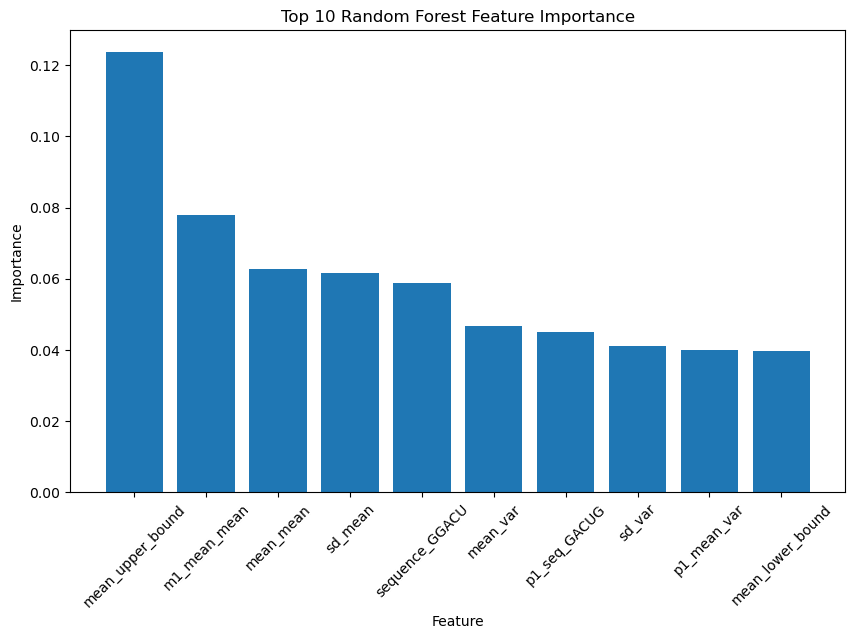

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Get the indices of features sorted by importance


indices = np.argsort(feature_importances)[::-1]

# Select the top 10 features
top_n = 10
top_feature_indices = indices[:top_n]

# Plot the feature importances for the top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), feature_importances[top_feature_indices], align="center")
plt.xticks(range(top_n), data.columns[top_feature_indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top 10 Random Forest Feature Importance")
plt.show()
